### Load packages

In [371]:
# flopy
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf
import flopy.mf6 as mf6

# others
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
import geopandas as gpd
import rasterio


### Setup model

In [372]:
model_name = 'peat_testing_4'
workspace = "../testing_peat_module/Model_Testing_4"

sim = mf6.MFSimulation(
    sim_name=model_name, version="mf6", 
    exe_name="mf6", sim_ws=workspace)

### Load external spatial data

In [373]:
# Raster paths
demPath = "../testing_peat_module/Raster/INA_1sec_srtm_refine_48s_100m_clip.tif"
# Open files
demDs = gdal.Open(demPath)
# Get data as arrays
demData = demDs.GetRasterBand(1).ReadAsArray()
ztop = demDs.ReadAsArray()
zbot = np.linspace(-3/1, -3, 1 ) # set constant thickness of 10 units
ulx, cell_size, xskew, uly, yskew, ysize  = demDs.GetGeoTransform()

print(len(demData))
print(len(demData[0]))

105
117


### Setup model grid

(105, 117)

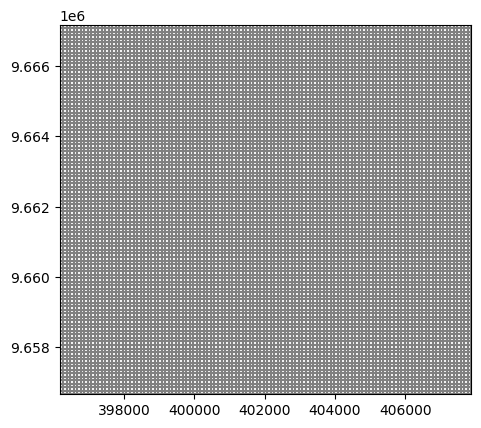

In [374]:
nper = 1
nlay = 1
nrow = demDs.RasterYSize
ncol = demDs.RasterXSize
delr = cell_size
delc = cell_size
xoffset, yoffset = ulx, uly
epsg = 32748

modelgrid = flopy.discretization.StructuredGrid(
    delr=np.ones(ncol) * delr,
    delc=np.ones(nrow) * delc,
    xoff=xoffset, yoff=9656668.75185826, angrot=0)

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')
# modelgrid.plot(ax=ax, linewidth=0.5, color='black')
# plt.show()

modelgrid.plot()
nrow, ncol

### Temporal discretization and Iteratie Matrix Solution Package

In [375]:
tdis = mf6.ModflowTdis(
    sim, time_units="days", nper=1, 
    perioddata=[(1.0, 1, 1.0)])

ims = mf6.ModflowIms(
    sim, complexity="moderate", 
    outer_dvclose=0.001)

### Groundwater level model

In [376]:
# create the model instance
gwf = mf6.ModflowGwf(
    sim, modelname=model_name, 
    save_flows=True)

# output control
oc = mf6.ModflowGwfoc(
    gwf, head_filerecord=f'{gwf.name}.hds', 
    budget_filerecord=f'{gwf.name}.cbc',
    saverecord=[('head', 'all'), ("budget", "all")])
                
# set up the discretization package
dis = mf6.ModflowGwfdis(
    gwf, nlay=nlay, nrow=nrow, ncol=ncol,
    delr=delr, delc=delc, 
    top=ztop, botm=zbot, idomain=1)



### Assign aquifer properties

In [377]:
hk = [1E-4]

npf = mf6.ModflowGwfnpf(
    gwf, icelltype=1, k=hk)

### Assign initial condition

In [378]:
ic = mf6.ModflowGwfic(gwf, strt=ztop-1)

### Grid intersect

In [379]:
ixs = GridIntersect(modelgrid, method= "structured")

ixs

### Boundary condition

#### River package

[[0, 104, 84, 0, 0.01, -1],
 [0, 104, 85, 6, 0.01, 5],
 [0, 103, 85, 1, 0.01, 0],
 [0, 103, 86, 6, 0.01, 5],
 [0, 103, 87, 7, 0.01, 6],
 [0, 102, 87, 3, 0.01, 2],
 [0, 102, 88, 4, 0.01, 3],
 [0, 101, 88, 10, 0.01, 9],
 [0, 101, 89, 22, 0.01, 21],
 [0, 100, 89, 9, 0.01, 8],
 [0, 100, 90, 7, 0.01, 6],
 [0, 100, 91, 4, 0.01, 3],
 [0, 99, 91, 0, 0.01, -1],
 [0, 99, 92, 6, 0.01, 5],
 [0, 98, 92, 9, 0.01, 8],
 [0, 98, 93, 6, 0.01, 5],
 [0, 97, 93, 4, 0.01, 3],
 [0, 97, 94, 11, 0.01, 10],
 [0, 96, 94, 6, 0.01, 5],
 [0, 96, 95, 5, 0.01, 4],
 [0, 95, 95, 7, 0.01, 6],
 [0, 95, 96, 5, 0.01, 4],
 [0, 94, 96, 3, 0.01, 2],
 [0, 94, 97, 3, 0.01, 2],
 [0, 93, 97, 4, 0.01, 3],
 [0, 93, 98, 5, 0.01, 4],
 [0, 92, 98, 6, 0.01, 5],
 [0, 91, 98, 5, 0.01, 4],
 [0, 91, 99, 8, 0.01, 7],
 [0, 90, 99, 7, 0.01, 6],
 [0, 90, 100, 8, 0.01, 7],
 [0, 89, 100, 6, 0.01, 5],
 [0, 89, 101, 4, 0.01, 3],
 [0, 88, 101, 4, 0.01, 3],
 [0, 88, 102, 5, 0.01, 4],
 [0, 87, 102, 4, 0.01, 3],
 [0, 86, 102, 3, 0.01, 2],
 [0, 85, 102

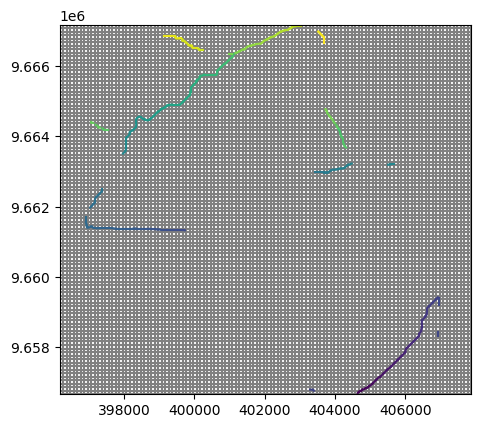

In [386]:
riv_path = "../testing_peat_module/Vector/stream_DEMNAS_dissolve.shp"
riv_hk = 0.01

riv_data = gpd.read_file(riv_path)
result = ixs.intersect(riv_data['geometry'].loc[0])
# print(pd.DataFrame(result))

fig, ax = plt.subplots(1, 1)
modelgrid.plot(ax=ax)
ixs.plot_linestring(result, ax=ax, cmap="viridis")

#apply parameters to intersect cells
river_list = []
for i in result.cellids:
    river_list.append([0, *i, demData[i], riv_hk, demData[i]-1])
riv_spd = {0:river_list}

river = mf6.ModflowGwfriv(gwf,
                          #pname="riv",
                          stress_period_data=riv_spd,
                          save_flows=True) 
# riv_data.plot()

river_list

#### Recharge package

In [381]:
#apply recharge on selected cells
rchr = 0.004
rchr_list = []
for i in result.cellids:
    rchr_list.append([0,*i,rchr])
rchr_spd = {0:rchr_list}

rch = mf6.ModflowGwfrch(gwf, stress_period_data=rchr_spd, pname="RCH")

rchr_list

[[0, 104, 84, 0.004],
 [0, 104, 85, 0.004],
 [0, 103, 85, 0.004],
 [0, 103, 86, 0.004],
 [0, 103, 87, 0.004],
 [0, 102, 87, 0.004],
 [0, 102, 88, 0.004],
 [0, 101, 88, 0.004],
 [0, 101, 89, 0.004],
 [0, 100, 89, 0.004],
 [0, 100, 90, 0.004],
 [0, 100, 91, 0.004],
 [0, 99, 91, 0.004],
 [0, 99, 92, 0.004],
 [0, 98, 92, 0.004],
 [0, 98, 93, 0.004],
 [0, 97, 93, 0.004],
 [0, 97, 94, 0.004],
 [0, 96, 94, 0.004],
 [0, 96, 95, 0.004],
 [0, 95, 95, 0.004],
 [0, 95, 96, 0.004],
 [0, 94, 96, 0.004],
 [0, 94, 97, 0.004],
 [0, 93, 97, 0.004],
 [0, 93, 98, 0.004],
 [0, 92, 98, 0.004],
 [0, 91, 98, 0.004],
 [0, 91, 99, 0.004],
 [0, 90, 99, 0.004],
 [0, 90, 100, 0.004],
 [0, 89, 100, 0.004],
 [0, 89, 101, 0.004],
 [0, 88, 101, 0.004],
 [0, 88, 102, 0.004],
 [0, 87, 102, 0.004],
 [0, 86, 102, 0.004],
 [0, 85, 102, 0.004],
 [0, 84, 102, 0.004],
 [0, 83, 102, 0.004],
 [0, 83, 103, 0.004],
 [0, 82, 103, 0.004],
 [0, 82, 104, 0.004],
 [0, 81, 104, 0.004],
 [0, 80, 104, 0.004],
 [0, 79, 104, 0.004],
 [0, 7

### Write simulation file

In [382]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model peat_testing_4...
    writing model name file...
    writing package oc...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 255 based on size of stress_period_data
    writing package rch...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 255 based on size of stress_period_data


In [383]:
sim.run_simulation()

FloPy is using the following executable to run the model: C:\Users\mwidijanto\AppData\Local\flopy\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 05:57:01 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither t

(True, [])

### Postprocessing

In [384]:
#open head file
hds = bf.HeadFile(workspace+'/'+model_name + '.hds')
head = hds.get_data()
head[head==-1e+30]=np.nan

np.unique(head)

array([4000.40585464, 4000.92360755, 4001.29087729, ..., 4016.79692929,
       4017.74759328, 4017.89360854])

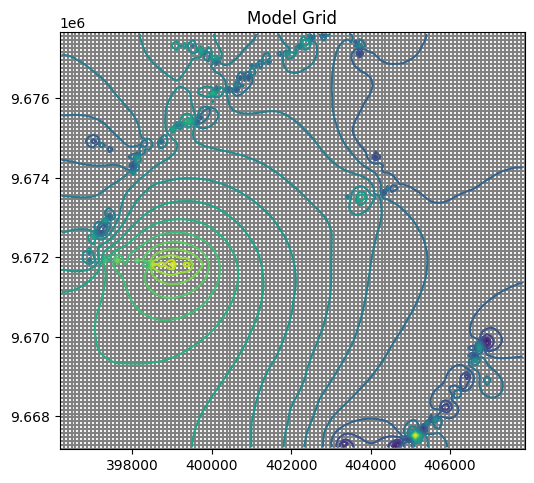

In [385]:
gwf.modelgrid.set_coord_info(
    xoff=xoffset, yoff=yoffset, epsg=epsg)
gwf.modelgrid

# plot model grid
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)
linecollection = mapview.plot_grid()

# plot model heads
levels = np.linspace(np.nanmin(head),np.nanmax(head),num=20)
contour_set = mapview.contour_array(head,levels=levels)
t = ax.set_title("Model Grid")


plt.show()